In [21]:
# Tendorflow imports
import tensorflow as tf

# Helper libraries
import math
import numpy as np
import matplotlib
matplotlib.use('PS') #prevent import error due to venv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

In [22]:
# Imports for dataset separation
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Import for model testing and curves
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import ConfusionMatrixDisplay

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

In [3]:
# get the data into slices
data_images = []
data_labels = []
rel_img_path = 'map-proj/' # add path of folder to image name for later loading

In [4]:
# open up the labeled data file
with open('labels-map-proj.txt') as labels:
  for line in labels:
    file_name, label = line.split(' ')
    data_images.append(rel_img_path + file_name)
    data_labels.append(int(label))

In [5]:
# divide data into testing and training (total len 3820)
train_images, test_images, train_labels, test_labels = train_test_split(
    data_images, data_labels, test_size=0.15, random_state=666)
test_len = len(test_images)   # 573
train_len = len(train_images) # 3247

In [6]:
# label translations
class_labels = ['other','crater','dark_dune','streak',
                'bright_dune','impact','edge']

In [7]:
#convert image paths into numpy matrices
def parse_image(filename):
  img_obj = Image.open(filename)
  img = np.asarray(img_obj).astype(np.float32)
  #normalize image to 0-1 range
  img /= 255.0
  return img

train_images = np.array(list(map(parse_image, train_images)))
test_images = np.array(list(map(parse_image, test_images)))

In [8]:
# convert labels to one-hot encoding
def to_one_hot(label):
  encoding = [0 for _ in range(len(class_labels))]
  encoding[label] = 1
  return np.array(encoding).astype(np.float32)

train_labels = np.array(list(map(to_one_hot, train_labels)))
test_labels = np.array(list(map(to_one_hot, test_labels)))

In [9]:
# model.fit requires train data to be in the shape of [batch, imDim1, imDim2, numChannels]
# slap extra dimension on the end of train images so tf will be happy
train_images = np.reshape(train_images, (-1, 227, 227, 1)) #add 4th dim
train_labels = np.reshape(train_labels, (-1, 7))
test_images = np.reshape(test_images, (-1, 227, 227, 1))
test_labels = np.reshape(test_labels, (-1, 7))

In [10]:
# make a generator to train the model with
generator = ImageDataGenerator(rotation_range=0, zoom_range=0,
    width_shift_range=0, height_shift_range=0, shear_range=0,
    horizontal_flip=False, fill_mode="nearest")

In [11]:
###             BUILD SHAPE OF THE MODEL              ###
# increase kernel size and stride??
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
      input_shape=(227,227,1)),
  tf.keras.layers.MaxPooling2D((2,2), strides=2),
  tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D((2,2), strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(7, activation=tf.nn.softmax), # final layer with node for each classification
])

In [12]:
# specify loss and SGD functions
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [13]:
###                 TRAIN THE MODEL                   ###
#specify training metadata
BATCH_SIZE = 32
print("about to train")
# train the model on the training data
num_epochs = 10 
history=model.fit_generator(generator.flow(train_images, train_labels, batch_size=BATCH_SIZE), 
                    epochs=num_epochs,
                    validation_data=(test_images,test_labels))

about to train


C:\Users\Swift3\AppData\Local\Temp\ipykernel_3856\3317037231.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator.flow(train_images, train_labels, batch_size=BATCH_SIZE),


Epoch 1/10
102/102 [==============================] - 319s 3s/step - loss: 1.0337 - accuracy: 0.6960 - val_loss: 0.7523 - val_accuracy: 0.7382
Epoch 2/10
102/102 [==============================] - 322s 3s/step - loss: 0.6363 - accuracy: 0.7767 - val_loss: 0.5964 - val_accuracy: 0.7906
Epoch 3/10
102/102 [==============================] - 305s 3s/step - loss: 0.4552 - accuracy: 0.8386 - val_loss: 0.7114 - val_accuracy: 0.7574
Epoch 4/10
102/102 [==============================] - 307s 3s/step - loss: 0.3279 - accuracy: 0.8817 - val_loss: 0.7705 - val_accuracy: 0.7574
Epoch 5/10
102/102 [==============================] - 308s 3s/step - loss: 0.2309 - accuracy: 0.9212 - val_loss: 0.7951 - val_accuracy: 0.8010
Epoch 6/10
102/102 [==============================] - 313s 3s/step - loss: 0.1581 - accuracy: 0.9529 - val_loss: 0.7614 - val_accuracy: 0.8045
Epoch 7/10
102/102 [==============================] - 323s 3s/step - loss: 0.1056 - accuracy: 0.9661 - val_loss: 0.9469 - val_accuracy: 0.7714

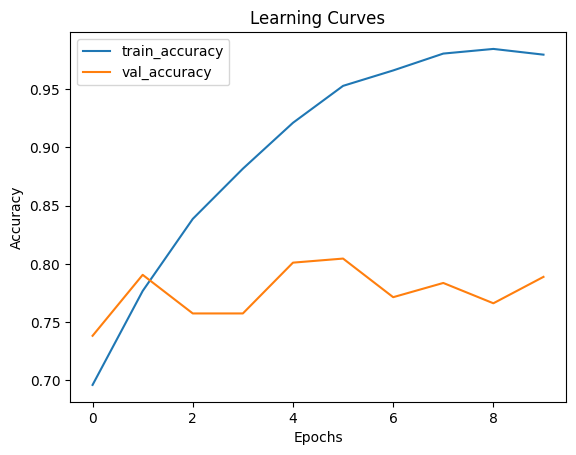

In [29]:
# Plot learning curves
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.savefig('LearningCurves.png')
plt.show()

In [15]:
# Predicting for test imgs
test_pred = model.predict(test_images)

18/18 [==============================] - 11s 603ms/step


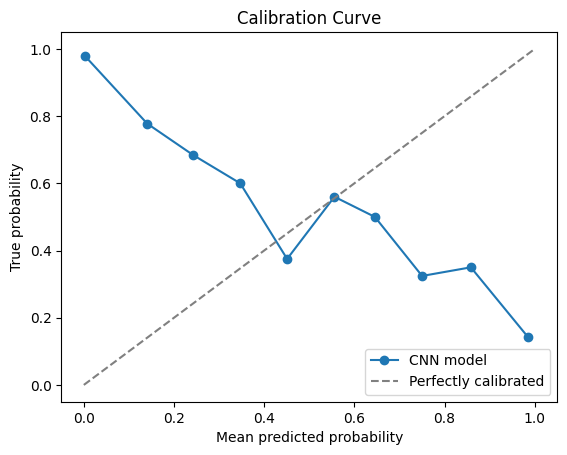

In [30]:
# Calculate true probabilities (mean predicted probabilities for each bin)
test_labels1, test_pred1 = calibration_curve(test_labels.flatten(), test_pred.flatten(), pos_label=0, n_bins=10)

# Plot Calibration Curve
plt.plot(test_pred1, test_labels1, marker='o', label='CNN model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.legend()
plt.savefig('CalibrationCurve.png')
plt.show()

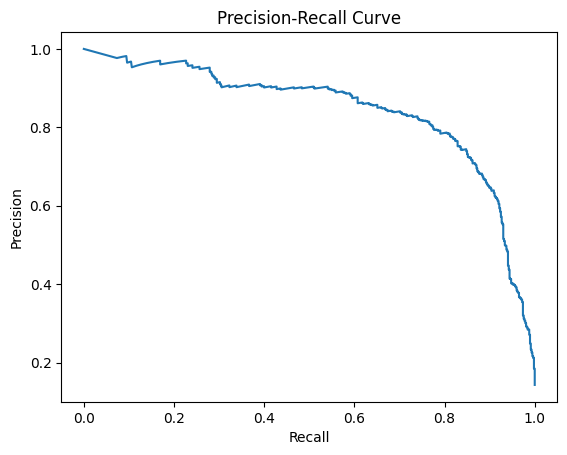

In [31]:
# Get precision and recall values
precision, recall, _dash_ = precision_recall_curve(test_labels.flatten(), test_pred.flatten())

# Plot Precision-Recall Curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig('PrecisionRecallCurve.png')
plt.show()

In [18]:
###             EVALUATE MODEL ACCURACY               ###
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Final loss was {}.\nAccuracy of model was {}".format(test_loss,test_accuracy))

18/18 [==============================] - 11s 609ms/step - loss: 0.9717 - accuracy: 0.7888
Final loss was 0.9717428684234619.
Accuracy of model was 0.7888306975364685


In [19]:
print("Model Scores:")

# Calculate accuracy
accuracy = accuracy_score(np.argmax(test_labels,axis=1), np.argmax(test_pred,axis=1))

# Calculate precision, recall, and F1 score
precision = precision_score(np.argmax(test_labels,axis=1), np.argmax(test_pred,axis=1), average='macro')  # You can change average to 'micro' or 'weighted' if needed
recall = recall_score(np.argmax(test_labels,axis=1), np.argmax(test_pred,axis=1), average='macro')
f1 = f1_score(np.argmax(test_labels,axis=1), np.argmax(test_pred,axis=1), average='macro')

# Calculate confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels,axis=1), np.argmax(test_pred,axis=1))

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Model Scores:
Accuracy: 0.7888307155322862
Precision: 0.7603764826603192
Recall: 0.6586281669898972
F1 Score: 0.691267723305264
Confusion Matrix:
 [[245  16  20   0   7  13]
 [ 29  29   1   0   0   0]
 [  9   1  50   0   0   3]
 [  2   0   0   2   0   0]
 [ 10   0   2   0   9   1]
 [  7   0   0   0   0 117]]


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (7).

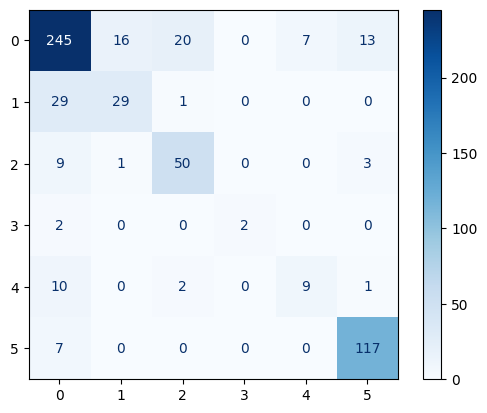

In [32]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.arange(7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('ConfusionMatrix.png')
plt.show()

In [28]:
model.save("modelv2.h5")
model.save("modelv2.keras")

C:\Users\Swift3\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
